# Calibration Test Burkina Faso

This notebook includes codes for performing calibration on burkina faso simulations. All simulation results are based on single pixel, and run with different configurations of beta value, treatment coverage, population and zone.

In [93]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np
from scipy.optimize import curve_fit

In [94]:
def combine_data_from_databases(data_folder, table_name, location_id=None):
    """
    Combines data from SQLite databases in a folder structure into a single DataFrame.

    Args:
        data_folder (str): Path to the root folder containing configuration folders.

    Returns:
        pd.DataFrame: Combined DataFrame with an additional column for configuration and simulation number.
    """
    combined_data = []

    # Iterate over each configuration folder
    for conf_name in os.listdir(data_folder):
        conf_path = os.path.join(data_folder, conf_name)

        if os.path.isdir(conf_path):
            # Iterate over each SQLite database in the configuration folder
            for sim_number, db_file in enumerate(os.listdir(conf_path), start=1):
                if db_file.endswith(".db"):
                    db_path = os.path.join(conf_path, db_file)

                    # Connect to the SQLite database
                    with sqlite3.connect(db_path) as conn:
                        # Assuming all databases have a common table names
                        if location_id:
                            query = f"SELECT * FROM {table_name} where locationid={location_id}"
                        else:
                            query= f"SELECT * FROM {table_name}"

                        try:
                            # Read the table into a DataFrame
                            df = pd.read_sql_query(query, conn)

                            # Add columns for configuration name and simulation number
                            df["Configuration"] = conf_name
                            df["Simulation"] = sim_number

                            # Append the DataFrame to the list
                            combined_data.append(df)
                        except Exception as e:
                            print(f"Error reading table from {db_path}: {e}")

    # Combine all DataFrames into a single DataFrame
    if combined_data:
        return pd.concat(combined_data, ignore_index=True)
    else:
        return pd.DataFrame()

In [111]:
data_folder = "output_files"
table_name = "monthlysitedata"
df = combine_data_from_databases(data_folder, table_name)

#particular calib date
#calib_date = max(df['monthlydataid']
# calib_date = pd.Timestamp("2022-01-01")
# df_filtered = df[(df.monthlydataid == calib_date)][['pfpr2to10','Configuration','Simulation']]
# df_filtered.reset_index(drop=True)


#average of calib year
start_date = pd.Timestamp("2007-01-01")
df['date'] = df['monthlydataid'].apply(lambda x: start_date + pd.DateOffset(months=x-1))
df_2022 = df[df['date'].dt.year == 2022]
df_filtered = df_2022.groupby(['Configuration', 'Simulation'], as_index=False)['pfpr2to10'].mean()
df_filtered

,Configuration,Simulation,pfpr2to10
0,1-10-0.55-0.001-bfa,1,0.000000
1,1-10-0.55-0.001-bfa,2,0.000000
2,1-10-0.55-0.001-bfa,3,0.000000
3,1-10-0.55-0.001-bfa,4,0.000000
4,1-10-0.55-0.001-bfa,5,0.000000
...,...,...,...
6835,1-50-0.85-1-bfa,11,63.437500
6836,1-50-0.85-1-bfa,12,58.661616
6837,1-50-0.85-1-bfa,13,71.424210
6838,1-50-0.85-1-bfa,14,63.892293


In [112]:
df_grouped_mean = df_filtered.groupby('Configuration')['pfpr2to10'].mean().reset_index()
df_grouped_std = df_filtered.groupby('Configuration')['pfpr2to10'].std().reset_index()

df_final = pd.merge(df_grouped_mean, df_grouped_std, on ='Configuration', suffixes=('_mean', '_std'))
df_final

,Configuration,pfpr2to10_mean,pfpr2to10_std
0,1-10-0.55-0.001-bfa,0.000000,0.000000
1,1-10-0.55-0.005-bfa,0.000000,0.000000
2,1-10-0.55-0.01-bfa,0.000000,0.000000
3,1-10-0.55-0.0125-bfa,0.000000,0.000000
4,1-10-0.55-0.015-bfa,0.000000,0.000000
...,...,...,...
451,1-50-0.85-0.4-bfa,41.724060,10.718143
452,1-50-0.85-0.5-bfa,41.470419,4.957936
453,1-50-0.85-0.6-bfa,46.837346,9.605799
454,1-50-0.85-0.8-bfa,55.664939,7.732503


In [113]:
# Split the 'Configuration' column into categorical columns
df_final[['Zone', 'Population', 'TreatmentAccess', 'Beta']] = df_final['Configuration'].str.extract(r'(\d+)-(\d+)-([\d.]+)-([\d.]+)-')

# Convert the new columns to appropriate data types
df_final['Zone'] = df_final['Zone'].astype(int)
df_final['Population'] = df_final['Population'].astype(int)
df_final['TreatmentAccess'] = df_final['TreatmentAccess'].astype(float)
df_final['Beta'] = df_final['Beta'].astype(float)

# Display the updated DataFrame
df_final


,Configuration,pfpr2to10_mean,pfpr2to10_std,Zone,Population,TreatmentAccess,Beta
0,1-10-0.55-0.001-bfa,0.000000,0.000000,1,10,0.55,0.0010
1,1-10-0.55-0.005-bfa,0.000000,0.000000,1,10,0.55,0.0050
2,1-10-0.55-0.01-bfa,0.000000,0.000000,1,10,0.55,0.0100
3,1-10-0.55-0.0125-bfa,0.000000,0.000000,1,10,0.55,0.0125
4,1-10-0.55-0.015-bfa,0.000000,0.000000,1,10,0.55,0.0150
...,...,...,...,...,...,...,...
451,1-50-0.85-0.4-bfa,41.724060,10.718143,1,50,0.85,0.4000
452,1-50-0.85-0.5-bfa,41.470419,4.957936,1,50,0.85,0.5000
453,1-50-0.85-0.6-bfa,46.837346,9.605799,1,50,0.85,0.6000
454,1-50-0.85-0.8-bfa,55.664939,7.732503,1,50,0.85,0.8000


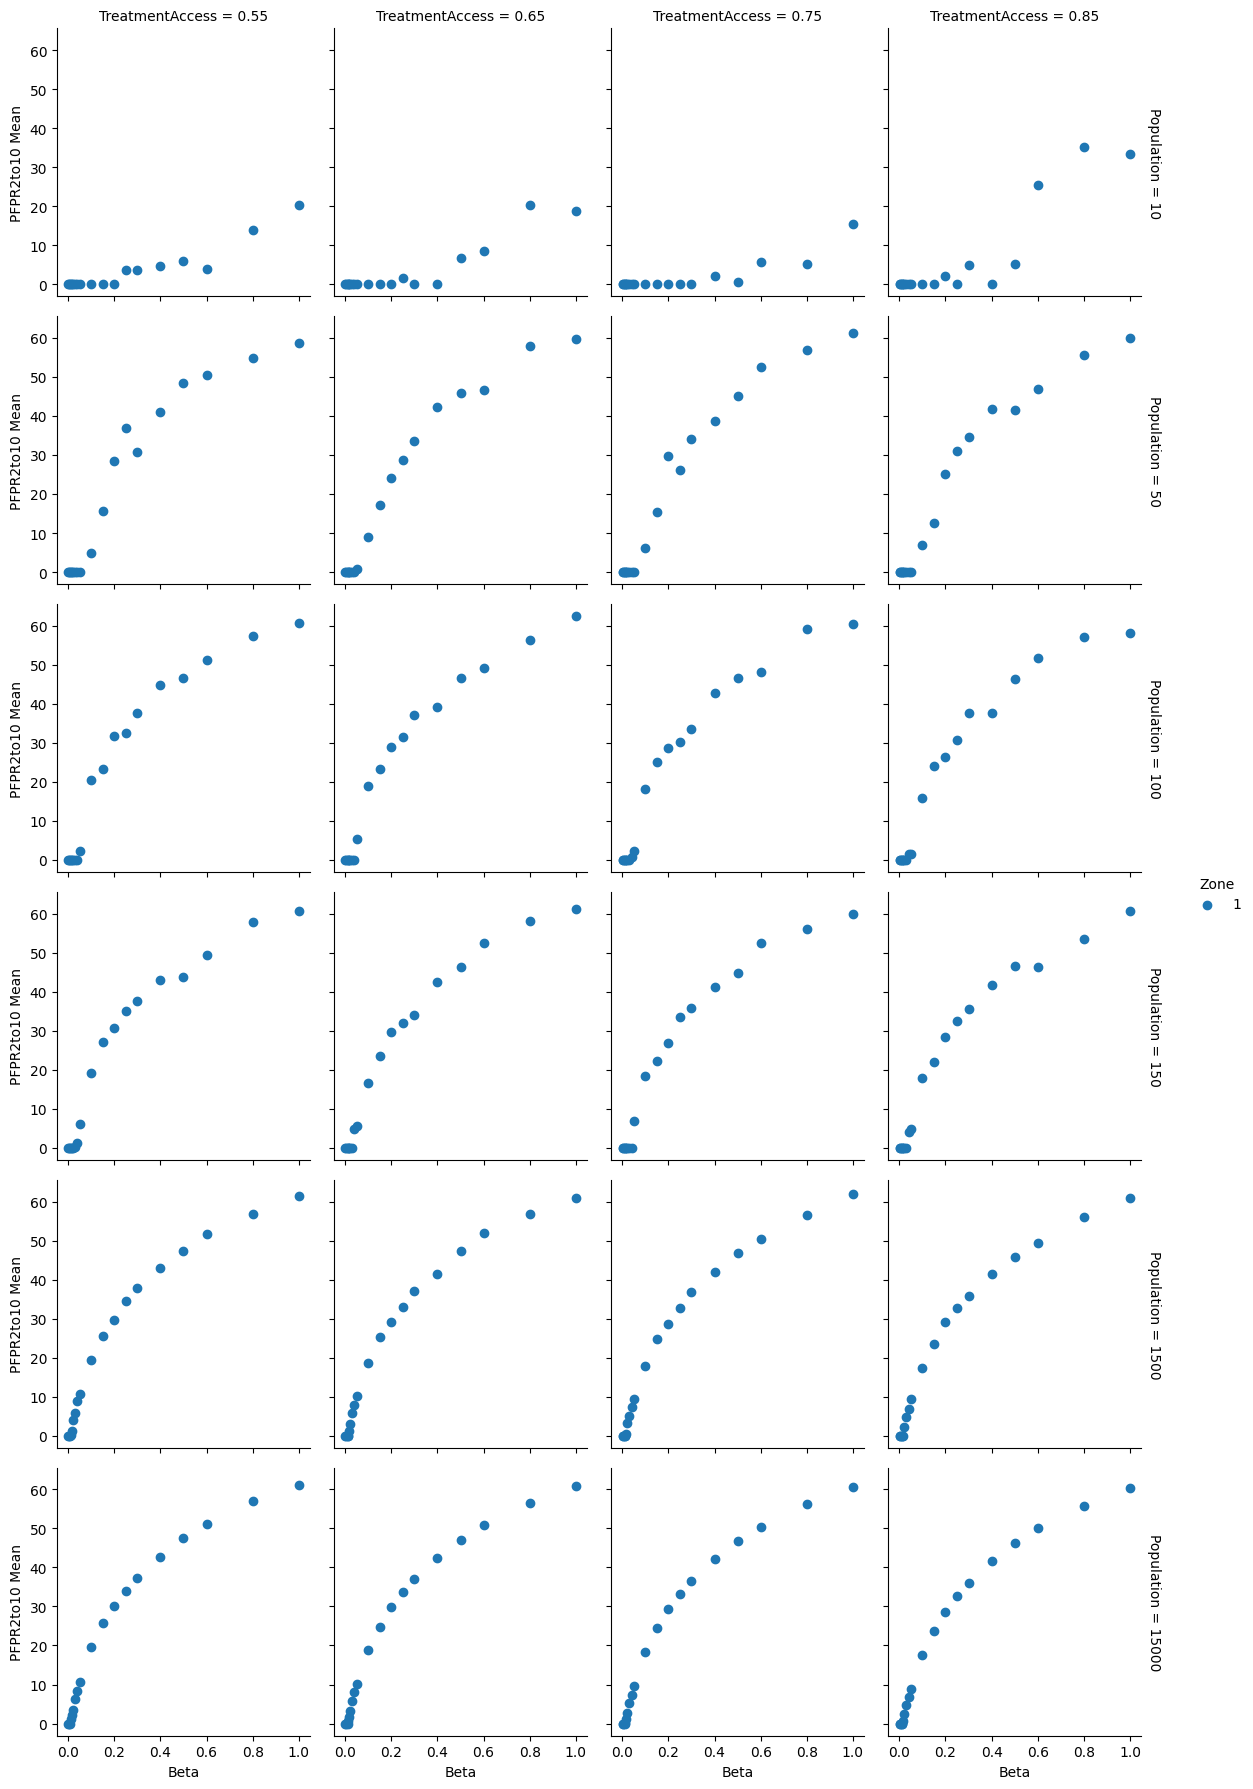

In [114]:
# Plotting a grid of scatter plots
g = sns.FacetGrid(df_final, col="TreatmentAccess", row="Population", hue="Zone", margin_titles=True)
g.map(plt.scatter, "Beta", "pfpr2to10_mean")
g.set_axis_labels("Beta", "PFPR2to10 Mean")
g.add_legend()
plt.show()

In [115]:
# Exploring difference in pfpr between two population sizes (Is it worth running simulations for 4 different population sizes?)
pop1 = 15000
pop2 = 150
access = 0.55
print(df_final[((df_final.Population==pop1) & (df_final.TreatmentAccess==access))][['Beta', 'pfpr2to10_mean']])
print(df_final[((df_final.Population==pop2) & (df_final.TreatmentAccess==access))][['Beta', 'pfpr2to10_mean']])

       Beta  pfpr2to10_mean
304  0.0010        0.000000
305  0.0050        0.000000
306  0.0100        0.000000
307  0.0125        1.118426
308  0.0150        2.115094
309  0.0200        3.556760
310  0.0300        6.180439
311  0.0400        8.365539
312  0.0500       10.624056
313  0.1000       19.558645
314  0.1500       25.665374
315  0.2000       30.241406
316  0.2500       33.983496
317  0.3000       37.380148
318  0.4000       42.717580
319  0.5000       47.468655
320  0.6000       51.121137
321  0.8000       57.009157
322  1.0000       61.199539
       Beta  pfpr2to10_mean
152  0.0010        0.000000
153  0.0050        0.000000
154  0.0100        0.000000
155  0.0125        0.000000
156  0.0150        0.000000
157  0.0200        0.000000
158  0.0300        0.233792
159  0.0400        1.212743
160  0.0500        6.214486
161  0.1000       19.123075
162  0.1500       27.179654
163  0.2000       30.661848
164  0.2500       35.009576
165  0.3000       37.495214
166  0.4000       42

/tmp/ipykernel_452912/1142337737.py:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


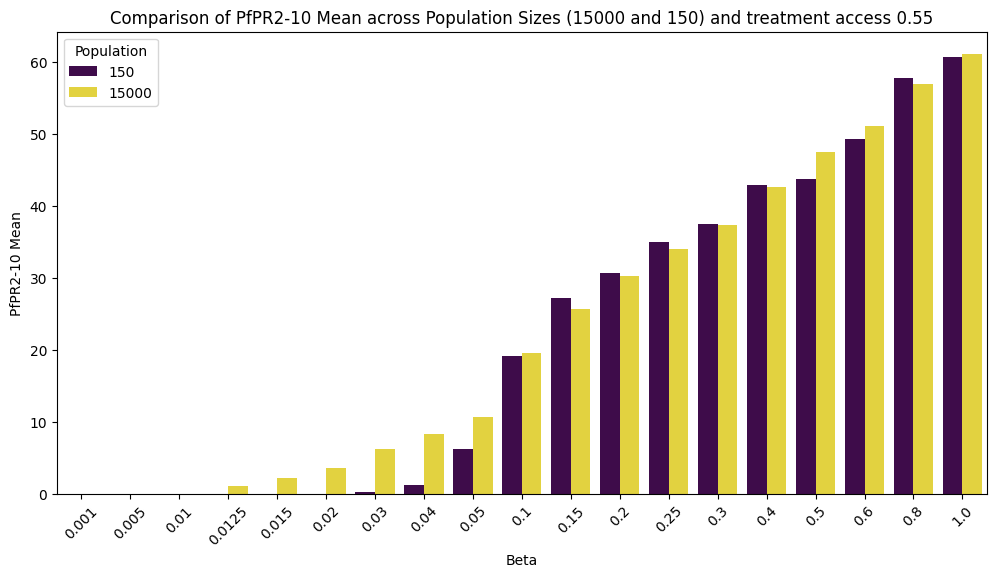

In [116]:
# Filter data for Population pop1 and pop2
df_filtered = df_final[(df_final.Population.isin([pop1, pop2])) & (df_final.TreatmentAccess==access)]

# Set figure size
plt.figure(figsize=(12, 6))

# Bar plot with 'Beta' on x-axis, 'pfpr2to10_mean' on y-axis, and hue for Population
sns.barplot(
    data=df_filtered,
    x="Beta",
    y="pfpr2to10_mean",
    hue="Population",
    dodge=True,
    palette="viridis",
    ci=None
)

# Customize plot
plt.xlabel("Beta")
plt.ylabel("PfPR2-10 Mean")
plt.title(f"Comparison of PfPR2-10 Mean across Population Sizes ({pop1} and {pop2}) and treatment access {access}")
plt.legend(title="Population")
plt.xticks(rotation=45)

# Show plot
plt.show()

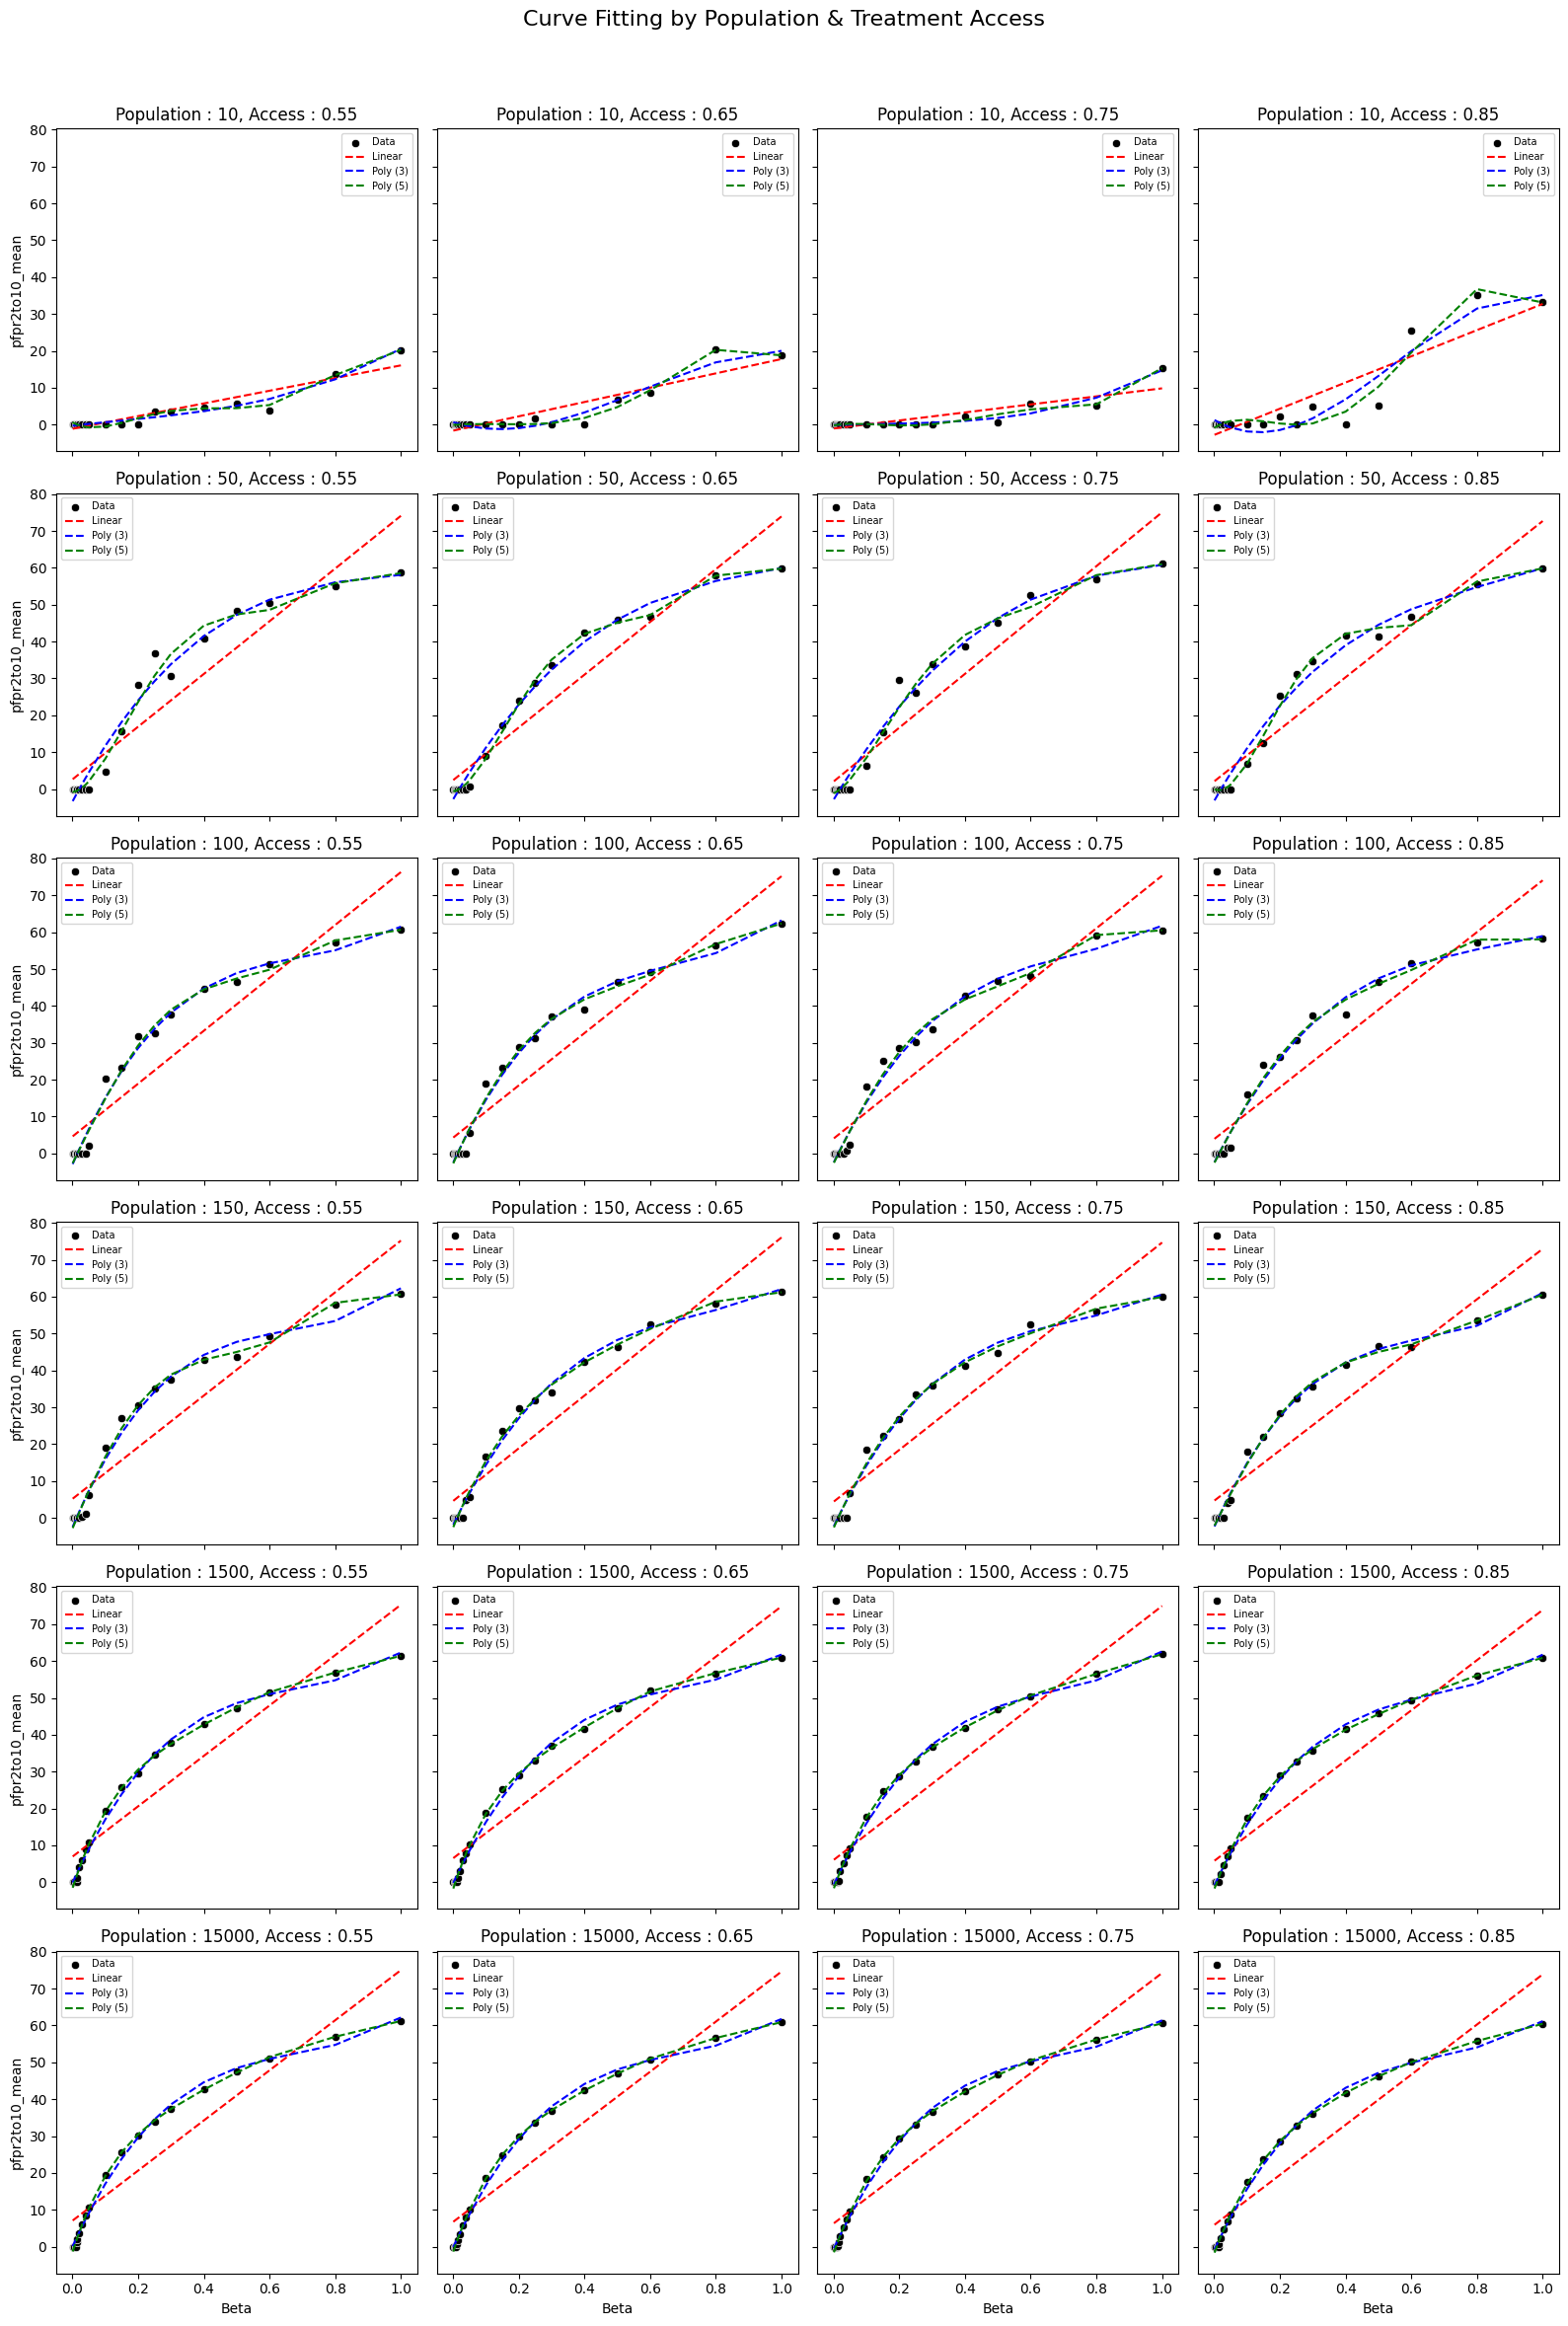

In [117]:
# Curve Fitting (liear and polynomial regression models)
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from scipy.interpolate import UnivariateSpline

# Get unique Population and TreatmentAccess values
populations = sorted(df_final['Population'].unique())  # Rows
treatment_accesses = sorted(df_final['TreatmentAccess'].unique())  # Columns

# Determine grid size
num_rows = len(populations)
num_cols = len(treatment_accesses)

# Create subplots grid
fig, axes = plt.subplots(num_rows, num_cols, figsize=(4 * num_cols, 4 * num_rows), sharex=True, sharey=True)

# Ensure axes is always a 2D list for consistency
if num_rows == 1:
    axes = np.array([axes])  # Convert to 2D array
if num_cols == 1:
    axes = np.array([[ax] for ax in axes])  # Convert to 2D array

# Perform regression for each (Population, TreatmentAccess) group
for i, population in enumerate(populations):
    for j, treatment_access in enumerate(treatment_accesses):
        ax = axes[i, j]  # Select subplot location
        
        # Filter the data for the current Population and TreatmentAccess
        group = df_final[(df_final['Population'] == population) & (df_final['TreatmentAccess'] == treatment_access)]
        
        if group.empty:
            ax.set_visible(False)  # Hide empty plots
            continue
        
        
        X = group[['Beta']].values 
        y = group['pfpr2to10_mean'].values  
        
        

        # 1. Linear Regression
        model = LinearRegression()
        model.fit(X, y)

        # 2. Polynomial Regression (degree 3)
        poly_model3 = make_pipeline(PolynomialFeatures(3), LinearRegression())
        poly_model3.fit(X, y)

        # 3. Polynomial Regression (degree 5)
        poly_model5 = make_pipeline(PolynomialFeatures(5), LinearRegression())
        poly_model5.fit(X, y)

        # 4. Spline Regression
        spline_model = UnivariateSpline(group['Beta'], group['pfpr2to10_mean'], s=50)

        # Plot regression
        sns.scatterplot(x=group['Beta'], y=group['pfpr2to10_mean'], ax=ax, label="Data", color='black')
        ax.plot(group['Beta'], model.predict(X), color='red', linestyle="dashed", label="Linear")
        ax.plot(group['Beta'], poly_model3.predict(X), color='blue', linestyle="dashed", label="Poly (3)")
        ax.plot(group['Beta'], poly_model5.predict(X), color='green', linestyle="dashed", label="Poly (5)")
        #ax.plot(group['Beta'], spline_model(X), color='purple', linestyle="dashed", label="Spline")

        # Setting titles & labels
        ax.set_title(f"Population : {population}, Access : {treatment_access}")
        if j == 0:
            ax.set_ylabel("pfpr2to10_mean")  
        if i == num_rows - 1:
            ax.set_xlabel("Beta")  
        ax.legend(fontsize=7)

# Adjust layout
plt.suptitle("Curve Fitting by Population & Treatment Access", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [156]:
'''
# Curve Fitting (X as pfpr and y as beta)
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from scipy.interpolate import UnivariateSpline



# Get unique Population and TreatmentAccess values
populations = sorted(df_final['Population'].unique())  # Rows
treatment_accesses = sorted(df_final['TreatmentAccess'].unique())  # Columns

# Determine grid size
num_rows = len(populations)
num_cols = len(treatment_accesses)

# Create subplots grid
fig, axes = plt.subplots(num_rows, num_cols, figsize=(4 * num_cols, 4 * num_rows), sharex=True, sharey=True)

# Ensure axes is always a 2D list for consistency
if num_rows == 1:
    axes = np.array([axes])  # Convert to 2D array
if num_cols == 1:
    axes = np.array([[ax] for ax in axes])  # Convert to 2D array

# Perform regression for each (Population, TreatmentAccess) group
for i, population in enumerate(populations):
    for j, treatment_access in enumerate(treatment_accesses):
        ax = axes[i, j]  # Select subplot location
        
        # Filter the data for the current Population and TreatmentAccess
        group = df_final[(df_final['Population'] == population) & (df_final['TreatmentAccess'] == treatment_access)]
        
        if group.empty:
            ax.set_visible(False)  # Hide empty plots
            continue
        
        
        X = group[['pfpr2to10_mean']].values  # Predictor
        y = group['Beta'].values  # Response variable
        
        

        # 1. Linear Regression
        model = LinearRegression()
        model.fit(X, y)

        # 2. Polynomial Regression (degree 3)
        poly_model3 = make_pipeline(PolynomialFeatures(3), LinearRegression())
        poly_model3.fit(X, y)

        # 3. Polynomial Regression (degree 5)
        poly_model5 = make_pipeline(PolynomialFeatures(5), LinearRegression())
        poly_model5.fit(X, y)

        # 4. Spline Regression
        spline_model = UnivariateSpline(group['pfpr2to10_mean'], group['Beta'], s=50)

        # Plot regression
        sns.scatterplot(x=group['Beta'], y=group['pfpr2to10_mean'], ax=ax, label="Data", color='black')
        ax.plot(model.predict(X), group['pfpr2to10_mean'], color='red', linestyle="dashed", label="Linear")
        ax.plot(poly_model3.predict(X), group['pfpr2to10_mean'],  color='blue', linestyle="dashed", label="Poly (3)")
        ax.plot(poly_model5.predict(X), group['pfpr2to10_mean'], color='green', linestyle="dashed", label="Poly (5)")
        ax.plot(spline_model(X), group['pfpr2to10_mean'], color='purple', linestyle="dashed", label="Spline")

        # Titles & Labels
        ax.set_title(f"Pop {population}, Access {treatment_access}")
        if j == 0:
            ax.set_ylabel("pfpr2to10_mean")  # Label only on first column
        if i == num_rows - 1:
            ax.set_xlabel("Beta")  # Label only on last row
        ax.legend(fontsize=7)

# Adjust layout
plt.suptitle("Curve Fitting by Population & Treatment Access", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()
'''


'\n# Curve Fitting (X as pfpr and y as beta)\nfrom sklearn.linear_model import LinearRegression\nfrom sklearn.preprocessing import PolynomialFeatures\nfrom sklearn.pipeline import make_pipeline\nfrom scipy.interpolate import UnivariateSpline\n\n\n\n# Get unique Population and TreatmentAccess values\npopulations = sorted(df_final[\'Population\'].unique())  # Rows\ntreatment_accesses = sorted(df_final[\'TreatmentAccess\'].unique())  # Columns\n\n# Determine grid size\nnum_rows = len(populations)\nnum_cols = len(treatment_accesses)\n\n# Create subplots grid\nfig, axes = plt.subplots(num_rows, num_cols, figsize=(4 * num_cols, 4 * num_rows), sharex=True, sharey=True)\n\n# Ensure axes is always a 2D list for consistency\nif num_rows == 1:\n    axes = np.array([axes])  # Convert to 2D array\nif num_cols == 1:\n    axes = np.array([[ax] for ax in axes])  # Convert to 2D array\n\n# Perform regression for each (Population, TreatmentAccess) group\nfor i, population in enumerate(populations):\n   

In [122]:
# Function to find Beta values corresponding to an array of pfpr values

def find_beta(pfpr_target, linear_model, popt, pfpr_cutoff):
    
  
    pfpr_target = np.array(pfpr_target)  # Ensure input is a NumPy array
    beta_values = np.zeros_like(pfpr_target, dtype=np.float64)  # Placeholder for results

    # Linear region: pfpr_target < cutoff
    mask_linear = pfpr_target < pfpr_cutoff
    #print(pfpr_target, pfpr_cutoff)
    #print("any mask linear: ", np.any(mask_linear))
    if np.any(mask_linear):
        beta_log_linear = (pfpr_target[mask_linear] - linear_model.intercept_) / linear_model.coef_[0]
        beta_values[mask_linear] = 10**(beta_log_linear)  # Convert back from log-space

    # Sigmoid region: pfpr_target >= cutoff
    mask_sigmoid = pfpr_target >= pfpr_cutoff
    if np.any(mask_sigmoid):
        a, b, c = popt
        beta_log_sigmoid = c - (1 / b) * np.log(a / pfpr_target[mask_sigmoid] - 1)
        beta_values[mask_sigmoid] = 10**(beta_log_sigmoid)  # Convert back from log-space

    return beta_values

/tmp/ipykernel_452912/1814112310.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['pfpr2to10_mean'] = group['pfpr2to10_mean'] / 100
/tmp/ipykernel_452912/1814112310.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['Beta'] = np.log10(group['Beta'])
/tmp/ipykernel_452912/1056914500.py:21: RuntimeWarning: divide by zero encountered in divide
  beta_log_sigmoid = c - (1 / b) * np.log(a / pfpr_target[mask_sigmoid] - 1)
/tmp/ipykernel_452912/1814112310.py:31: SettingWithCopyWarning: 
A value i

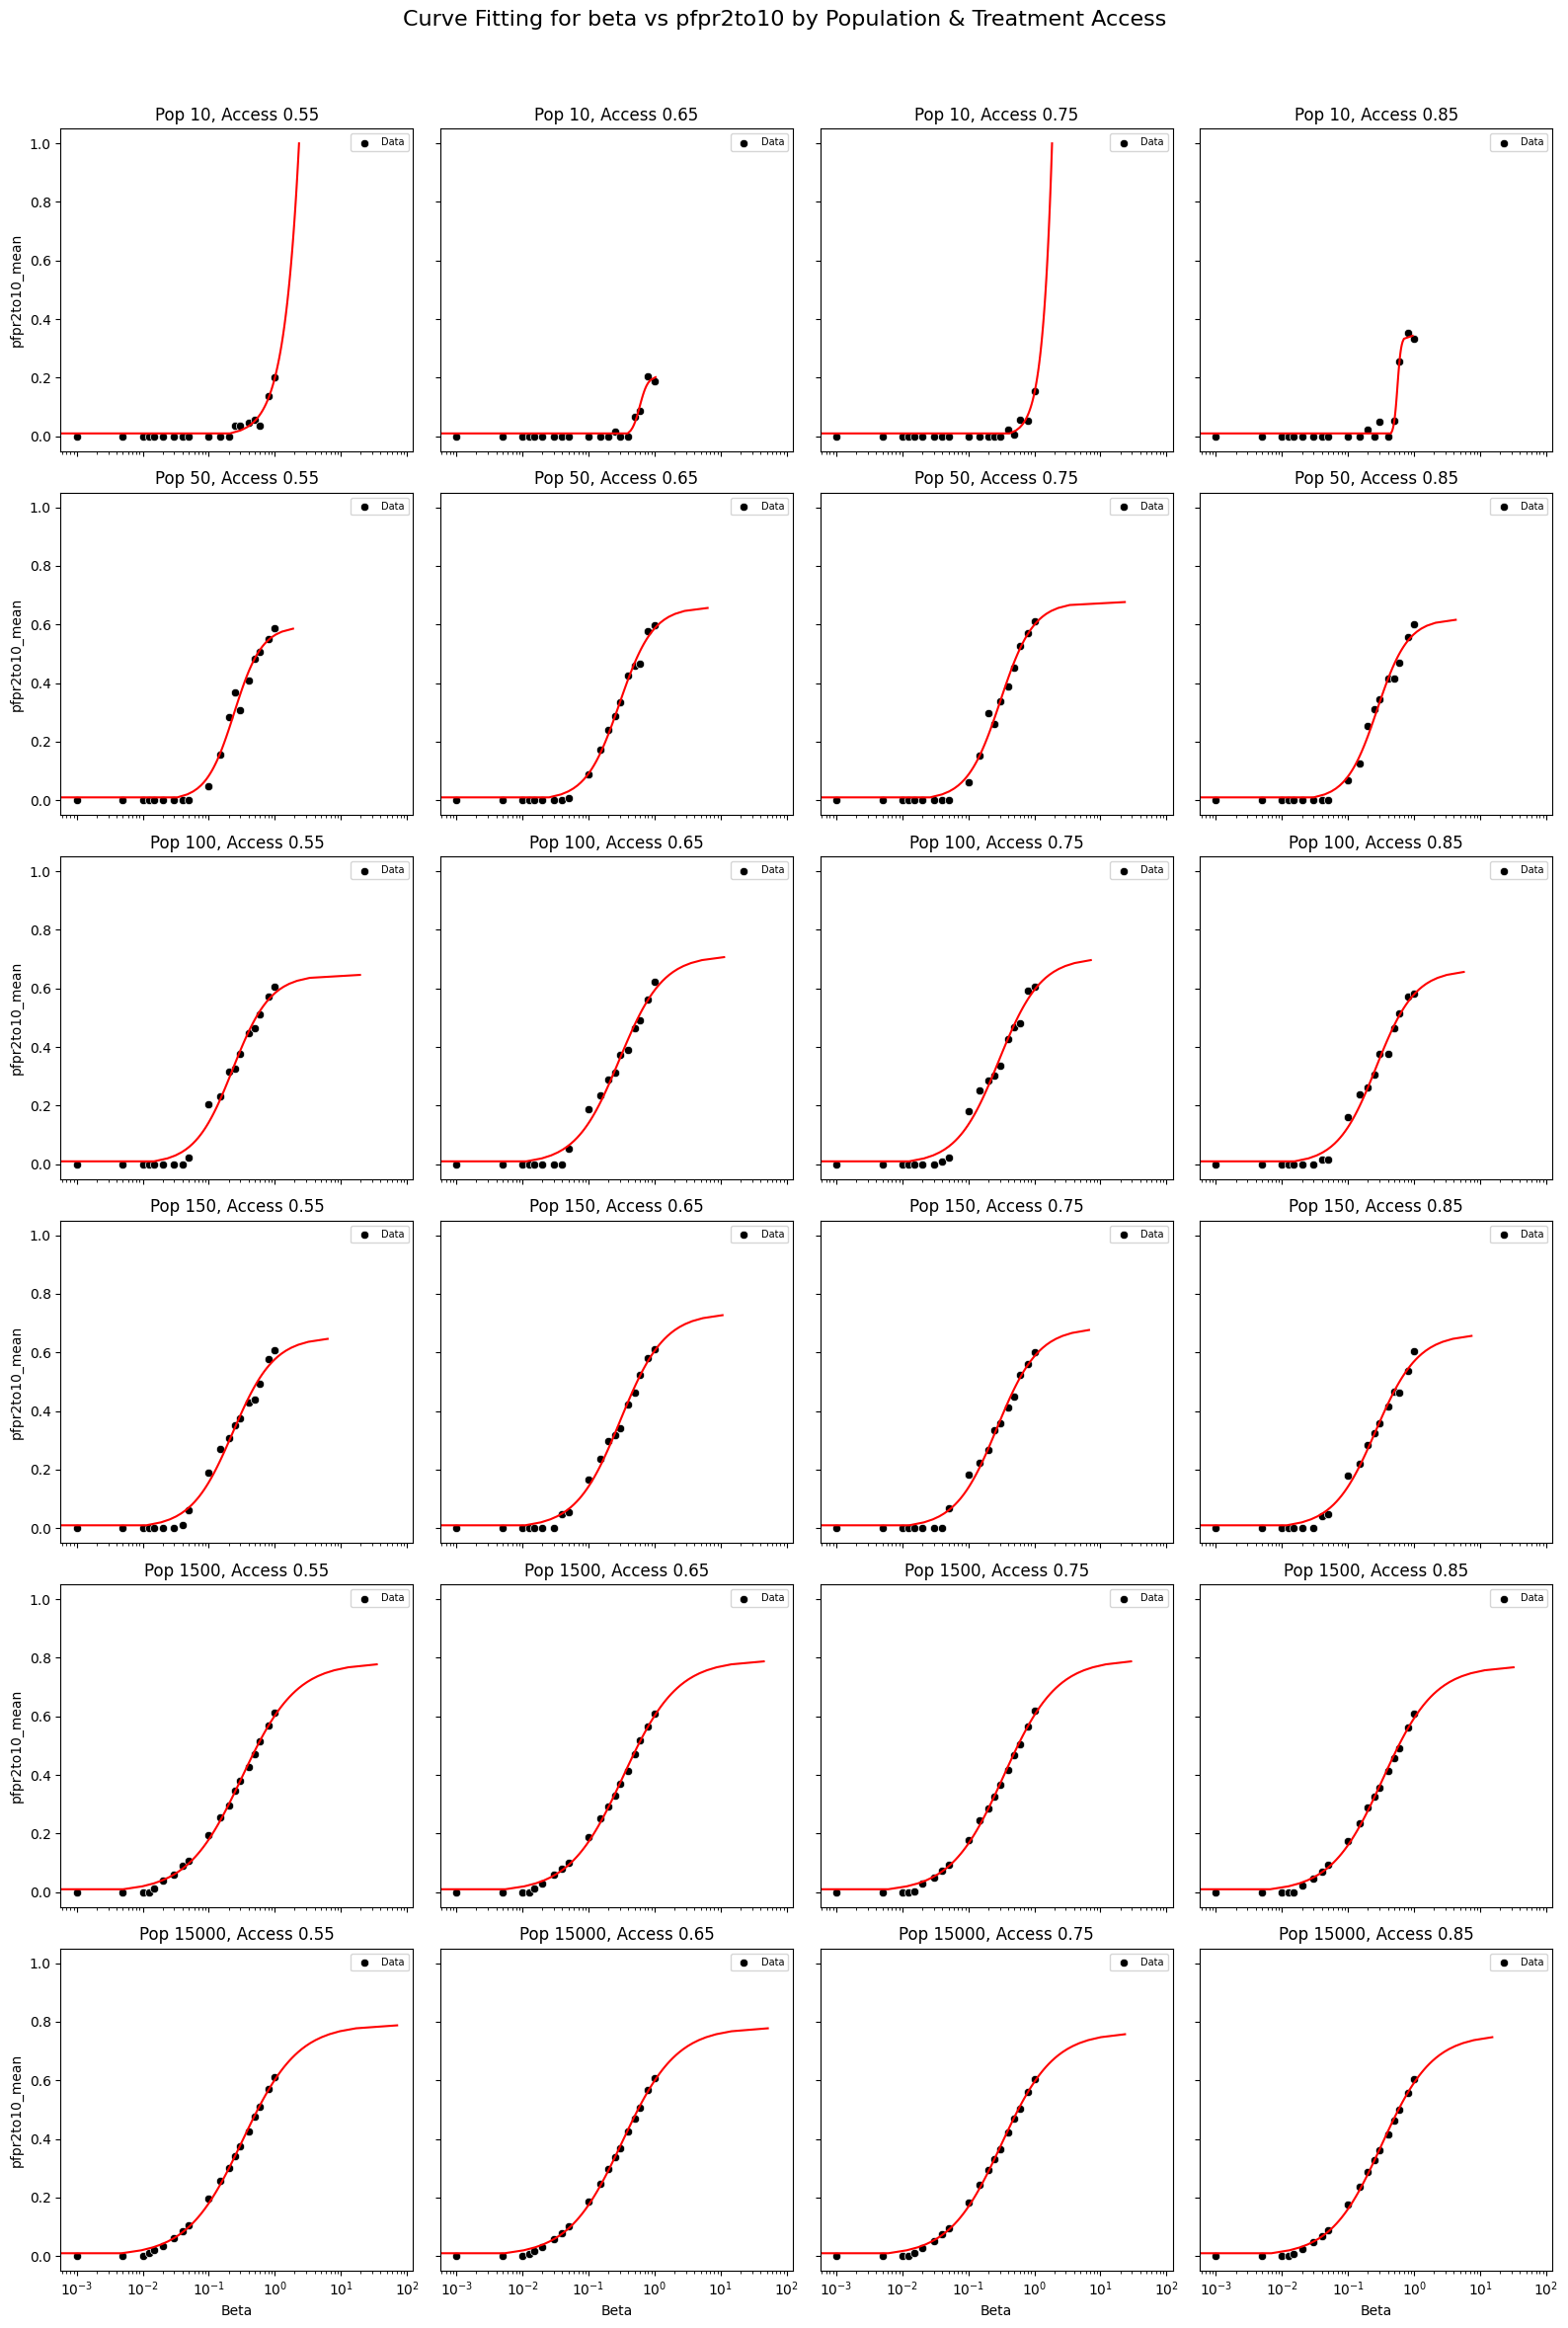

In [129]:
# Get unique Population and TreatmentAccess values
populations = sorted(df_final['Population'].unique())  # Rows
treatment_accesses = sorted(df_final['TreatmentAccess'].unique())  # Columns

# Determine grid size
num_rows = len(populations)
num_cols = len(treatment_accesses)

# Create subplots grid
fig, axes = plt.subplots(num_rows, num_cols, figsize=(4 * num_cols, 4 * num_rows), sharex=True, sharey=True)

# Ensure axes is always a 2D list for consistency
if num_rows == 1:
    axes = np.array([axes])  # Convert to 2D array
if num_cols == 1:
    axes = np.array([[ax] for ax in axes])  # Convert to 2D array

# Define cutoff based on pfpr2to10_mean
pfpr_cutoff = 0.0  # Set the desired cutoff for pfpr2to10_mean

models_map = {} #stores trained model for every parameter configuration

# Perform regression for each (Population, TreatmentAccess) group
for i, population in enumerate(populations):
    for j, treatment_access in enumerate(treatment_accesses):
        ax = axes[i, j]  # Select subplot location
        
        # Filter the data for the current Population and TreatmentAccess
        group = df_final[(df_final['Population'] == population) & (df_final['TreatmentAccess'] == treatment_access)]
        
        group['pfpr2to10_mean'] = group['pfpr2to10_mean'] / 100
        group['Beta'] = np.log10(group['Beta'])
        
        if group.empty:
            ax.set_visible(False)  # Hide empty plots
            continue
        
        X = group[['Beta']].values  # Log of Predictor (Beta)
        y = group['pfpr2to10_mean'].values  # Response variable
        
        # Determine cutoff Beta based on pfpr2to10_mean
        if any(y < pfpr_cutoff):
            cutoff_beta = np.max(X[y < pfpr_cutoff])  # Largest Beta where pfpr2to10_mean <= cutoff
        else:
            cutoff_beta = float('-inf')  # No cutoff
            
        #print(pfpr_cutoff)
        #print(cutoff_beta)
        #print(X.ravel())
        
        # Linear Regression on data before cutoff
        mask_linear = X.ravel() < cutoff_beta
        #print("mask_linear", mask_linear)
        if np.sum(mask_linear) > 1:
            X_linear = X[mask_linear].reshape(-1, 1)
            y_linear = y[mask_linear]
            linear_model = LinearRegression()
            linear_model.fit(X_linear, y_linear)
        else:
            linear_model = None
        
        # Sigmoid Regression on data after cutoff
        mask_sigmoid = X.ravel() >= cutoff_beta
        
        # Define sigmoid function
        def sigmoid_fit(x, a, b, c):
            return a / (1 + np.exp(-b * (x - c)))
        
        if np.sum(mask_sigmoid) > 1:
            X_sigmoid = X[mask_sigmoid].flatten()
            y_sigmoid = y[mask_sigmoid]
            popt, _ = curve_fit(sigmoid_fit, X_sigmoid, y_sigmoid, maxfev=10000)
        else:
            popt = None
            
            
        models_map[(population, treatment_access)] = (linear_model, popt)
        
        # Predictions
        pfpr_targets = np.linspace(0, 1, 100).reshape(-1, 1)
        #pfpr_targets = np.linspace(0.01, 1, 99).reshape(-1, 1) # To avoid divide by 0 error
        
        X_plot = find_beta(pfpr_targets, linear_model, popt, pfpr_cutoff)
        
        #X_plot = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
        
        ax.set_xscale('log')
        
        # sns.scatterplot(x=np.exp(group['Beta']), y=group['pfpr2to10_mean'], ax=ax, label="Data", color='black')
        sns.scatterplot(x=10**(group['Beta']), y=group['pfpr2to10_mean'], ax=ax, label="Data", color='black')
        ax.plot(X_plot,pfpr_targets, color='red')
        
        '''
        if linear_model is not None:
            y_linear_pred = linear_model.predict(X_plot[X_plot.ravel() <= cutoff_beta].reshape(-1, 1))
            ax.plot(np.exp(X_plot[X_plot.ravel() <= cutoff_beta]), y_linear_pred, color='red', linestyle="dashed", label="Linear")
            #ax.plot(X_plot[X_plot.ravel() <= cutoff_beta], y_linear_pred, color='red', linestyle="dashed", label="Linear")
        
        if popt is not None:
            y_sigmoid_pred = sigmoid_fit(X_plot[X_plot.ravel() > cutoff_beta].flatten(), *popt)
            ax.plot(np.exp(X_plot[X_plot.ravel() > cutoff_beta]), y_sigmoid_pred, color='blue', linestyle="dashed", label="Sigmoid")
            #ax.plot(X_plot[X_plot.ravel() <= cutoff_beta], y_linear_pred, color='red', linestyle="dashed", label="Linear")
        '''
        
        # Titles & Labels
        ax.set_title(f"Pop {population}, Access {treatment_access}")
        if j == 0:
            ax.set_ylabel("pfpr2to10_mean")  # Label only on first column
        if i == num_rows - 1:
            ax.set_xlabel("Beta")  # Label only on last row
        ax.legend(fontsize=7)
        

# Adjust layout
plt.suptitle("Curve Fitting for beta vs pfpr2to10 by Population & Treatment Access", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [131]:
def read_raster_data(folder, filename):
    raster_data = []
    nodata_value = -9999
    path = os.path.join(folder, filename)
    
    

    with open(path, 'r') as f:
        # Read header lines
        header = [next(f).strip() for _ in range(6)]  # Store metadata header
        
        # Read and store raster data in 2D format
        for line in f:
            row = [float(value) if value != str(nodata_value) else nodata_value for value in line.split()]
            # row = []
            # for value in line.split():
            #     print(value, nodata_value)
            #     print(value!=str(nodata_value))
            #     if value!=str(nodata_value):
            #         row.append(float(value))
            #     else:  
            #         row.append(nodata_value)
            #         print(row)
            
            raster_data.append(row)
    
    # Convert to NumPy array
    raster_data = np.array(raster_data)
    valid_data = raster_data[raster_data != nodata_value]
    
    print("data: ", valid_data)
    print("max: ", np.max(valid_data))
    print("min: ", np.min(valid_data))
    
    return header, raster_data



def  map_raster_values(pfpr2to10, population, treatment_access, get_beta_from_pfpr, nodata_value=-9999):
    
    #mapped_data = []
    
    #for i, pfpr2to10 in enumerate()
    
    # mapped_data = np.where(pfpr2to10 == nodata_value, nodata_value, get_beta_from_pfpr(pfpr2to10))
    # return mapped_data
    

    #get_beta_from_pfpr_vectorized = np.vectorize(get_beta_from_pfpr)
    
        
    

    # Apply the vectorized function
    #mapped_data = np.where(pfpr2to10 == nodata_value, nodata_value, get_beta_from_pfpr_vectorized(pfpr2to10, population, treatment_access))
    
    mapped_data = np.zeros_like(pfpr2to10)


    for i in range(pfpr2to10.shape[0]): 
        for j in range(pfpr2to10.shape[1]): 
            if pfpr2to10[i, j] != nodata_value:
                mapped_data[i, j] = get_beta_from_pfpr(pfpr2to10[i, j], population[i, j], treatment_access[i, j])
            else:
                mapped_data[i, j] = nodata_value
    
    
    return mapped_data



def print_raster(header, raster_data, output_filename):

    for line in header:
        print(line)  # Print header lines

    for row in raster_data:
        print(" ".join(map(str, row)))  # Print raster values in the same format
        
        
    try:
        with open(output_filename, 'w') as f:
            for line in header:
                f.write(line + '\n')  # Write header lines with newline

            for row in raster_data:
                f.write(" ".join(map(str, row)) + '\n')  # Write row with spaces and newline

        print(f"Raster data written to {output_filename}")
    except Exception as e:
        print(f"Error writing raster data to {output_filename}: {e}")


# Function to calculate beta
def get_beta_from_pfpr(value, population, treatment_access):
    #return spline_model(value) # Change the function used to predict beta from pfpr
    
    if value== -9999:
        return -9999
        
    population_buckets = [10, 50, 100, 150, 1500, 15000]
    treatment_access_buckets = [0.55, 0.65, 0.75, 0.85]
    
    population_mapped = 15000 # all population greater than 15000 will be mapped to 15000
    treatment_access_mapped = 0.85 # all treatment access greater than 0.75 will be mapped to 0.85
    
    for bucket in population_buckets:
        if population < bucket:
            population_mapped = bucket
            break

    for bucket in treatment_access_buckets:
        if treatment_access < bucket:
            treatment_access_mapped = bucket
            break
    
    
    conf = (population_mapped, treatment_access_mapped)
    
    linear_model, popt = models_map[conf]
    
    
    beta = find_beta(value, linear_model, popt, pfpr_cutoff)
    
    
    print("returing beta: ", beta)
    return beta

folder = "raster_files"
header, pfpr2to10 = read_raster_data(folder, "bfa_pfpr2to10.asc")
header, treatment_access = read_raster_data(folder, "bfa_treatmentseeking.asc")
header, population = read_raster_data(folder, "bfa_initialpopulation.asc")

print(pfpr2to10.shape)
print(treatment_access.shape)
print(population.shape)

beta_values = map_raster_values(pfpr2to10, population, treatment_access, get_beta_from_pfpr) 
print_raster(header, beta_values, "beta.asc")

data:  [0.1624021 0.14893   0.1415368 ... 0.4721123 0.4823237 0.3859914]
max:  0.5106495
min:  0.07769768
data:  [0.66  0.66  0.66  ... 0.615 0.615 0.615]
max:  0.84
min:  0.553
data:  [ 34.  63.  76. ... 258. 167. 232.]
max:  178519.0
min:  4.0
(130, 177)
(130, 177)
(130, 177)
returing beta:  0.1555891981670619
returing beta:  0.1092267423993795
returing beta:  0.10417899575848982
returing beta:  0.1051800613905734
returing beta:  0.10769126668531122
returing beta:  0.10338619311172131
returing beta:  0.10902534713664161
returing beta:  0.14211779106001085
returing beta:  0.14329682629031756
returing beta:  1.0688339770199862
returing beta:  0.12818182242900242
returing beta:  0.11972618312491583
returing beta:  0.1008718062903532
returing beta:  0.10864117942144536
returing beta:  0.12072540221007415
returing beta:  0.09872660144543771
returing beta:  0.0911778653550969
returing beta:  0.08632839913715133
returing beta:  0.10419177134425467
returing beta:  1.0077537492090953
returing

/tmp/ipykernel_452912/1056914500.py:21: RuntimeWarning: invalid value encountered in log
  beta_log_sigmoid = c - (1 / b) * np.log(a / pfpr_target[mask_sigmoid] - 1)


### MISC

In [83]:
header, raster_data = read_raster_data("raster_files", "bfa_treatmentseeking.asc")

np.unique(raster_data)

data:  [0.66  0.66  0.66  ... 0.615 0.615 0.615]
max:  0.84
min:  0.553


array([-9.999e+03,  5.530e-01,  6.150e-01,  6.350e-01,  6.600e-01,
        6.720e-01,  7.400e-01,  7.670e-01,  7.720e-01,  7.740e-01,
        8.080e-01,  8.270e-01,  8.290e-01,  8.400e-01])